# Fine-tuning ViLT For visual question answering (VQA)

In this notebook, we are going to illustrate how to fine-tune the Vision-and-Language Transformer (ViLT) for visual question answering. This is going to be very similar to how one would fine-tune BERT: one just places a head on top that is randomly initialized, and trains it end-to-end together with a pre-trained base.

* Paper: https://arxiv.org/abs/2102.03334
* ViLT docs: https://huggingface.co/docs/transformers/master/en/model_doc/vilt


## Set-up environment

First, we install the Transformers library.

In [1]:
!pip install -q transformers

## Load data

Next, we load the data. The data of VQAv2 can be obtained from the [official website](https://visualqa.org/download.html).

For demonstration purposes, we only download the validation dataset. We download:
* the images (stored in a single folder)
* the questions (stored in a JSON)
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

I've downloaded the images myself, and stored them locally.

### Read questions

First, we read the questions.

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

# List files in the current directory
files = os.listdir(current_directory)

# Find the file with the name "questions.json"
questions_json_files = [file for file in files if file.endswith('.json') and 'questions' in file]

# Print the paths of all files matching the pattern
for file in questions_json_files:
    print(os.path.join(current_directory, file))

import json
from google.colab import files
f = files.upload()

file = open("/content/questions.json")

import json

try:
    with open('questions.json', 'r') as file:
        # Return JSON object as dictionary
        data_questions = json.load(file)
        print(data_questions.keys())
except json.JSONDecodeError as e:
    print("Error decoding JSON:", e)


Saving questions.json to questions.json
dict_keys(['info', 'license', 'data_subtype', 'tast_type', 'data_type', 'questions'])


Let's see how many questions there are:

In [3]:
questions = data_questions['questions']
print("Number of questions:", len(questions))

Number of questions: 315


That's quite a lot! Let's take a look at the first one:

In [4]:
questions[0]

{'question': 'is this nurse putting on latex gloves?',
 'question_id': 11,
 'image_id': 1}

As we can see, this question is related to an image with a certain ID. How can we find back which image this is? The function below allows to get the ID from a corresponding filename. We'll use it to map between image IDs and their corresponding filenames.

In [5]:
from typing import Optional
import re

# Assuming you have a regex pattern for matching the filename
filename_re = re.compile(r'^(\d+)_.*$')

def id_from_filename(filename: str) -> Optional[int]:
    # Strip leading zeros from the filename
    filename_without_zeros = filename.lstrip('0')

    # Remove the trailing ".jpg" if present
    filename_without_extension = filename_without_zeros.replace('.PNG', '')
    filename_without_extension = filename_without_extension.replace('.png', '')

    return int(filename_without_extension)

# Example usage
filename = '0123.PNG'
id = id_from_filename(filename)
print(id)

123


In [6]:
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm

from google.colab import files
f = files.upload()

import zipfile
import io

# Get the uploaded zip archive file
uploaded_zip_filename = next(iter(f))

# Extract the contents of the zip archive
with zipfile.ZipFile(io.BytesIO(f[uploaded_zip_filename]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Function to list all files in a directory recursively
def list_files_recursive(root_dir):
    file_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Get the filename without the directory path
            file_name = os.path.basename(file)
            file_names.append(file_name)
    return file_names

# Get the list of all files in the '/content/' directory and its subdirectories
file_names = list_files_recursive('/content/Images')

# Print the list of file names
print(file_names)


Saving Images.zip to Images.zip
['0122.PNG', '296.png', '0234.PNG', '0029.PNG', '0252.PNG', '0096.PNG', '0181.PNG', '0142.PNG', '0277.PNG', '0232.PNG', '0134.PNG', '0270.PNG', '0233.PNG', '0156.PNG', '0151.PNG', '0150.PNG', '0124.PNG', '0259.PNG', '0021.PNG', '0172.PNG', '0174.PNG', '0129.PNG', '0240.PNG', '0086.PNG', '0022.PNG', '0141.PNG', '0101.PNG', '0269.PNG', '0136.PNG', '308.PNG', '0046.PNG', '0041.PNG', '0247.PNG', '0264.png', '0128.PNG', '0078.PNG', '0025.PNG', '0262.png', '0235.PNG', '0276.PNG', '0037.PNG', '0019.PNG', '0092.PNG', '0271.PNG', '0256.PNG', '0117.PNG', '303.PNG', '0237.PNG', '282.png', '0200.PNG', '0104.PNG', '0197.PNG', '0159.PNG', '0267.PNG', '0201.PNG', '0248.PNG', '0265.PNG', '0061.PNG', '301.PNG', '0008.PNG', '0183.PNG', '0218.PNG', '0106.PNG', '0093.PNG', '0111.PNG', '0217.PNG', '290.png', '0165.PNG', '288.png', '0261.png', '0118.PNG', '0032.PNG', '297.png', '0010.PNG', '0186.PNG', '0060.PNG', '0137.PNG', '0132.PNG', '0026.PNG', '284.png', '0158.PNG', '018

We can map a filename to its ID as follows:

In [7]:
id_from_filename('0001.PNG')

1

We create 2 dictionaries, one that maps filenames to their IDs and one the other way around:

In [8]:
root = "/content/Images/"
import zipfile
import io

filename_to_id = {root + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

print(filename_to_id)
print(id_to_filename)

{'/content/Images/0122.PNG': 122, '/content/Images/296.png': 296, '/content/Images/0234.PNG': 234, '/content/Images/0029.PNG': 29, '/content/Images/0252.PNG': 252, '/content/Images/0096.PNG': 96, '/content/Images/0181.PNG': 181, '/content/Images/0142.PNG': 142, '/content/Images/0277.PNG': 277, '/content/Images/0232.PNG': 232, '/content/Images/0134.PNG': 134, '/content/Images/0270.PNG': 270, '/content/Images/0233.PNG': 233, '/content/Images/0156.PNG': 156, '/content/Images/0151.PNG': 151, '/content/Images/0150.PNG': 150, '/content/Images/0124.PNG': 124, '/content/Images/0259.PNG': 259, '/content/Images/0021.PNG': 21, '/content/Images/0172.PNG': 172, '/content/Images/0174.PNG': 174, '/content/Images/0129.PNG': 129, '/content/Images/0240.PNG': 240, '/content/Images/0086.PNG': 86, '/content/Images/0022.PNG': 22, '/content/Images/0141.PNG': 141, '/content/Images/0101.PNG': 101, '/content/Images/0269.PNG': 269, '/content/Images/0136.PNG': 136, '/content/Images/308.PNG': 308, '/content/Images

We can now find back the image to which the question 'Where is he looking?' corresponded:

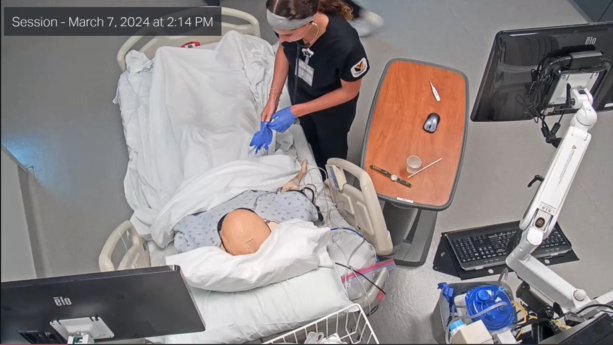

In [9]:
from PIL import Image

path = id_to_filename[questions[0]['image_id']]
image = Image.open(path)
image

### Read annotations

Next, let's read the annotations. As we'll see, every image is annotated with multiple possible answers.

In [10]:
import json

# Read annotations
f = open('/content/annotations.json')

# Return JSON object as dictionary
data_annotations = json.load(f)
print(data_annotations.keys())

dict_keys(['info', 'license', 'data_subtype', 'annotations'])


As we can see, there are 214354 annotations in total (for the validation dataset only!).

In [11]:
annotations = data_annotations['annotations']

In [12]:
print("Number of train images:", len(annotations))

Number of train images: 312


Let's take a look at the first one. As we can see, the example contains several answers (collected by different human annotators). The answer to a question can be a bit subjective: for instance for the question "where is he looking?", some people annotated this with "down", others with "table", another one with "skateboard", etc. So there's a bit of disambiguity among the annotators :)

In [13]:
annotations[0]

{'question_type': 'is this',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}],
 'image_id': 1,
 'answer_type': 'yes/no',
 'question_id': 11}

## Add labels + scores

Due to this ambiguity, most authors treat the VQAv2 dataset as a multi-label classification problem (as multiple answers are possibly valid). Moreover, rather than just creating a one-hot encoded vector, one creates a soft encoding, based on the number of times a certain answer appeared in the annotations.

For instance, in the example above, the answer "down" seems to be selected way more often than "skateboard". Hence, we want the model to give more emphasis on "down" than on "skateboard". We can achieve this by giving a score of 1.0 to labels which are counted at least 3 times, and a score < 1.0 for labels that are counted less.

We'll add 2 keys to each annotations:
* labels, which is a list of integer indices of the labels that apply to a given image + question.
* scores, which are the corresponding scores (between 0 and 1), which indicate the importance of each label.

As we'll need the id2label mapping from the VQA dataset, we load it from the hub as follows:

In [14]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

In [15]:
from tqdm.notebook import tqdm

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = answer_count[answer]
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

  0%|          | 0/312 [00:00<?, ?it/s]

Let's verify an example:

In [16]:
annotations[0]

{'question_type': 'is this',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}],
 'image_id': 1,
 'answer_type': 'yes/no',
 'question_id': 11,
 'labels': [3],
 'scores': [1]}

Let's verify the labels and corresponding scores:

In [17]:
labels = annotations[0]['labels']
print([config.id2label[label] for label in labels])

['yes']


In [18]:
scores = annotations[0]['scores']
print(scores)

[1]


## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltImageProcessor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [19]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[annotation['image_id']]).convert('RGB')
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        #print("labels: ",labels)
        #print("array: ", [config.id2label[label] for label in labels])
        scores = annotation['scores']
        #print("scores: ", scores)
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        #print("targets: ", targets)
        for label, score in zip(labels, scores):
              #print("score: ", score)
              #print("label: ", label)
              targets[label] = score
        # we want encoding["labels"] and targets to be the same as [config.id2label[label] for label in labels]
        encoding["labels"] = targets
        #print(encoding["labels"])

        return encoding

In [20]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = VQADataset(questions=questions,
                     annotations=annotations,
                     processor=processor)

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [22]:
processor.decode(dataset[0]['input_ids'])

'[CLS] is this nurse putting on latex gloves? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [23]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
lst = []
lst.append(labels)

In [24]:
[config.id2label[label] for label in lst]

['yes']

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [25]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

Next, we create a corresponding PyTorch DataLoader, which allows us to iterate over the dataset in batches.

Due to the fact that the processor resizes images to not necessarily the same size, we leverage the `pad_and_create_pixel_mask` method of the processor to pad the pixel values of a batch and create a corresponding pixel mask, which is a tensor of shape (batch_size, height, width) indicating which pixels are real (1) and which are padding (0).

In [26]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

Let's verify a batch:

In [27]:
batch = next(iter(train_dataloader))

In [28]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 608])
pixel_mask torch.Size([4, 384, 608])
labels torch.Size([4, 3129])


We can verify a given training example, by visualizing the image:

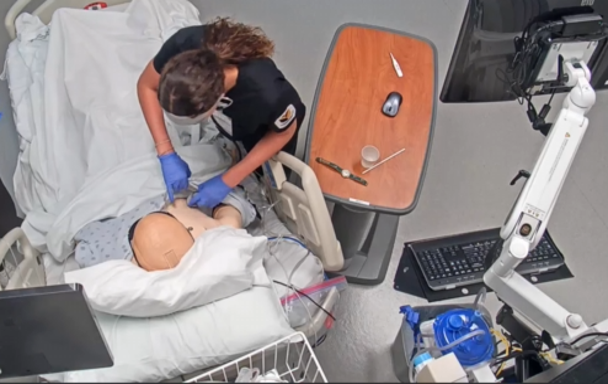

In [29]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [30]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] is this nurse listening to patients chest? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [31]:
labels = torch.nonzero(batch['labels'][batch_idx]).squeeze().tolist()

In [32]:
lst = []
lst.append(labels)

In [33]:
[config.id2label[label] for label in lst]

['no']

## Train a model

Finally, let's train a model! Note that I haven't done any hyperparameter tuning as this notebook was just created for demo purposes. I'd recommend going over the [ViLT paper](https://arxiv.org/abs/2102.03334) for better training settings.

I just wanted to illustrate that you can make the model overfit this dataset.

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2251.576904296875
Loss: 2202.394775390625
Loss: 2114.64501953125
Loss: 2058.5810546875
Loss: 1999.980224609375
Loss: 1941.69970703125
Loss: 1884.3353271484375
Loss: 1828.2000732421875
Loss: 1772.208740234375
Loss: 1720.3856201171875
Loss: 1667.86572265625
Loss: 1615.1219482421875
Loss: 1565.3172607421875
Loss: 1515.8685302734375
Loss: 1469.931884765625
Loss: 1418.64990234375
Loss: 1372.1695556640625
Loss: 1328.2744140625
Loss: 1286.2237548828125
Loss: 1243.0870361328125
Loss: 1201.798828125
Loss: 1162.48974609375
Loss: 1125.193603515625
Loss: 1088.550537109375
Loss: 1051.905517578125
Loss: 1017.8602905273438
Loss: 985.2973022460938
Loss: 953.8155517578125
Loss: 922.406005859375
Loss: 892.0222778320312
Loss: 863.6389770507812
Loss: 835.7813110351562
Loss: 809.0841064453125
Loss: 782.9367065429688
Loss: 757.616943359375
Loss: 733.3118896484375
Loss: 710.3316040039062
Loss: 687.9185791015625
Loss: 666.1101684570312
Loss: 645.2052001953125
Loss: 625.1502075195312
Loss: 605.8248291015

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 232.97552490234375
Loss: 228.031494140625
Loss: 223.57794189453125
Loss: 219.16783142089844
Loss: 214.90280151367188
Loss: 210.78158569335938
Loss: 206.75933837890625
Loss: 203.0869140625
Loss: 199.3692626953125
Loss: 195.6973419189453
Loss: 192.34657287597656
Loss: 188.70787048339844
Loss: 185.3628692626953
Loss: 182.11695861816406
Loss: 178.79656982421875
Loss: 176.0859375
Loss: 173.24148559570312
Loss: 170.1870574951172
Loss: 167.20521545410156
Loss: 164.46681213378906
Loss: 161.62290954589844
Loss: 159.1969757080078
Loss: 156.5857696533203
Loss: 154.27511596679688
Loss: 151.73284912109375
Loss: 149.53672790527344
Loss: 147.2556915283203
Loss: 144.94583129882812
Loss: 142.7261199951172
Loss: 140.6709747314453
Loss: 138.58172607421875
Loss: 136.4989776611328
Loss: 134.61380004882812
Loss: 132.81956481933594
Loss: 130.79293823242188
Loss: 128.9156951904297
Loss: 127.24365234375
Loss: 125.43401336669922
Loss: 123.78041076660156
Loss: 121.9926986694336
Loss: 120.345947265625
Loss:

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 77.42882537841797
Loss: 76.66094970703125
Loss: 75.89895629882812
Loss: 74.96127319335938
Loss: 74.2182388305664
Loss: 73.5711669921875
Loss: 72.84539794921875
Loss: 72.28379821777344
Loss: 71.6028060913086
Loss: 70.91901397705078
Loss: 70.24476623535156
Loss: 69.41016387939453
Loss: 68.93476867675781
Loss: 68.30591583251953
Loss: 67.85514068603516
Loss: 67.21797943115234
Loss: 66.42050170898438
Loss: 65.6557388305664
Loss: 65.35377502441406
Loss: 64.64288330078125
Loss: 64.1700210571289
Loss: 63.57510757446289
Loss: 62.90721893310547
Loss: 62.23162841796875
Loss: 61.77053451538086
Loss: 61.33101272583008
Loss: 60.74588394165039
Loss: 60.22317886352539
Loss: 59.707740783691406
Loss: 59.17662811279297
Loss: 58.66036605834961
Loss: 58.108642578125
Loss: 57.72872543334961
Loss: 57.25299072265625
Loss: 56.76926040649414
Loss: 56.119319915771484
Loss: 55.843204498291016
Loss: 55.40608215332031
Loss: 54.68855667114258
Loss: 54.67433166503906
Loss: 53.76096725463867
Loss: 53.82659912109

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 40.9429931640625
Loss: 40.62691116333008
Loss: 40.36629104614258
Loss: 40.13386535644531
Loss: 39.83279037475586
Loss: 39.57783508300781
Loss: 39.336265563964844
Loss: 39.06923294067383
Loss: 38.810611724853516
Loss: 38.570556640625
Loss: 38.345176696777344
Loss: 38.083763122558594
Loss: 37.82268524169922
Loss: 37.578338623046875
Loss: 37.31940841674805
Loss: 37.153648376464844
Loss: 36.88376235961914
Loss: 36.5970344543457
Loss: 36.352745056152344
Loss: 36.123294830322266
Loss: 35.8925666809082
Loss: 35.77598190307617
Loss: 35.678890228271484
Loss: 35.21195602416992
Loss: 35.00315856933594
Loss: 34.9176139831543
Loss: 34.71044158935547
Loss: 34.50585174560547
Loss: 34.60190200805664
Loss: 34.2266845703125
Loss: 33.750457763671875
Loss: 33.56418228149414
Loss: 33.262969970703125
Loss: 33.164268493652344
Loss: 32.97016525268555
Loss: 32.774654388427734
Loss: 32.71098709106445
Loss: 32.521751403808594
Loss: 32.479248046875
Loss: 31.853300094604492
Loss: 32.12584686279297
Loss: 31.7

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 26.073917388916016
Loss: 25.948156356811523
Loss: 25.813058853149414
Loss: 25.731582641601562
Loss: 25.54657745361328
Loss: 25.4498348236084
Loss: 25.328222274780273
Loss: 25.19120216369629
Loss: 25.062570571899414
Loss: 24.978351593017578
Loss: 24.852783203125
Loss: 24.699140548706055
Loss: 24.610410690307617
Loss: 24.446571350097656
Loss: 24.34615135192871
Loss: 24.25930404663086
Loss: 24.120576858520508
Loss: 24.019100189208984
Loss: 23.894990921020508
Loss: 23.814001083374023
Loss: 23.674293518066406
Loss: 23.557279586791992
Loss: 23.39699935913086
Loss: 23.339021682739258
Loss: 23.231260299682617
Loss: 23.18125343322754
Loss: 23.02513885498047
Loss: 22.961191177368164
Loss: 22.76453399658203
Loss: 22.70539093017578
Loss: 22.567537307739258
Loss: 22.532379150390625
Loss: 22.46802520751953
Loss: 22.317867279052734
Loss: 22.193849563598633
Loss: 22.085540771484375
Loss: 22.021183013916016
Loss: 21.866668701171875
Loss: 21.749919891357422
Loss: 21.721920013427734
Loss: 21.619413

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 18.579612731933594
Loss: 18.249897003173828
Loss: 18.174768447875977
Loss: 18.4254207611084
Loss: 18.016862869262695
Loss: 17.749040603637695
Loss: 18.46418571472168
Loss: 18.19392204284668
Loss: 17.917776107788086
Loss: 17.653799057006836
Loss: 17.586544036865234
Loss: 17.71072769165039
Loss: 17.628986358642578
Loss: 17.386011123657227
Loss: 17.33370590209961
Loss: 17.26019287109375
Loss: 17.18932342529297
Loss: 17.30299949645996
Loss: 17.057235717773438
Loss: 17.178491592407227
Loss: 17.115005493164062
Loss: 16.85437774658203
Loss: 16.59263038635254
Loss: 16.715436935424805
Loss: 16.645349502563477
Loss: 16.345685958862305
Loss: 17.018997192382812
Loss: 16.708648681640625
Loss: 16.65473747253418
Loss: 16.586212158203125
Loss: 16.516162872314453
Loss: 16.987470626831055
Loss: 16.636722564697266
Loss: 16.321983337402344
Loss: 16.251476287841797
Loss: 16.520069122314453
Loss: 16.259010314941406
Loss: 15.95411205291748
Loss: 15.99455738067627
Loss: 15.886487007141113
Loss: 15.92044

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 13.939023971557617
Loss: 13.902064323425293
Loss: 13.889402389526367
Loss: 13.817473411560059
Loss: 13.764577865600586
Loss: 13.745508193969727
Loss: 13.701971054077148
Loss: 13.635587692260742
Loss: 13.590680122375488
Loss: 13.493608474731445
Loss: 13.55092716217041
Loss: 13.459874153137207
Loss: 13.503803253173828
Loss: 13.388803482055664
Loss: 13.441107749938965
Loss: 13.206931114196777
Loss: 13.353657722473145
Loss: 13.041254043579102
Loss: 13.086997985839844
Loss: 13.235984802246094
Loss: 13.20512580871582
Loss: 13.154934883117676
Loss: 12.925110816955566
Loss: 13.126742362976074
Loss: 12.934074401855469
Loss: 12.890569686889648
Loss: 12.847005844116211
Loss: 12.798502922058105
Loss: 12.757750511169434
Loss: 12.725931167602539
Loss: 12.7012300491333
Loss: 12.631901741027832
Loss: 12.635316848754883
Loss: 12.547575950622559
Loss: 12.532150268554688
Loss: 12.547889709472656
Loss: 12.457858085632324
Loss: 12.374835014343262
Loss: 12.337678909301758
Loss: 12.29149341583252
Loss:

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 11.23326587677002
Loss: 10.955938339233398
Loss: 10.989872932434082
Loss: 10.914589881896973
Loss: 10.818473815917969
Loss: 10.839097023010254
Loss: 10.879590034484863
Loss: 10.852947235107422
Loss: 10.719642639160156
Loss: 10.577584266662598
Loss: 10.64272403717041
Loss: 10.749436378479004
Loss: 10.736292839050293
Loss: 10.5255708694458
Loss: 10.495734214782715
Loss: 10.889460563659668
Loss: 10.859155654907227
Loss: 10.610217094421387
Loss: 10.580272674560547
Loss: 10.548233985900879
Loss: 10.320024490356445
Loss: 10.494450569152832
Loss: 10.272829055786133
Loss: 10.61440372467041
Loss: 10.229818344116211
Loss: 10.375439643859863
Loss: 10.49627685546875
Loss: 10.160317420959473
Loss: 10.414291381835938
Loss: 10.24312686920166
Loss: 10.220328330993652
Loss: 10.009418487548828
Loss: 10.067790985107422
Loss: 10.127211570739746
Loss: 10.294015884399414
Loss: 10.164273262023926
Loss: 10.000825881958008
Loss: 10.029314994812012
Loss: 10.00350284576416
Loss: 9.984588623046875
Loss: 9.9

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 9.196038246154785
Loss: 9.155549049377441
Loss: 9.043750762939453
Loss: 9.181283950805664
Loss: 8.994483947753906
Loss: 8.973166465759277
Loss: 8.966840744018555
Loss: 8.913787841796875
Loss: 8.910174369812012
Loss: 8.958690643310547
Loss: 8.808774948120117
Loss: 8.952568054199219
Loss: 8.745505332946777
Loss: 8.72792911529541
Loss: 8.818857192993164
Loss: 8.790902137756348
Loss: 8.633880615234375
Loss: 9.046514511108398
Loss: 8.88123893737793
Loss: 8.843464851379395
Loss: 8.568739891052246
Loss: 8.469627380371094
Loss: 8.830950736999512
Loss: 8.542387962341309
Loss: 8.600175857543945
Loss: 8.510336875915527
Loss: 8.503884315490723
Loss: 8.527337074279785
Loss: 8.506507873535156
Loss: 8.44196605682373
Loss: 8.477672576904297
Loss: 8.526309967041016
Loss: 8.503166198730469
Loss: 8.377705574035645
Loss: 8.447724342346191
Loss: 8.3849515914917
Loss: 8.331957817077637
Loss: 8.372843742370605
Loss: 8.341663360595703
Loss: 8.309100151062012
Loss: 8.283818244934082
Loss: 8.2953157424926

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 7.714314937591553
Loss: 7.707266330718994
Loss: 7.454274654388428
Loss: 7.235484600067139
Loss: 7.434635639190674
Loss: 7.621783256530762
Loss: 8.022165298461914
Loss: 7.387650012969971
Loss: 7.388558387756348
Loss: 7.379990100860596
Loss: 7.534463405609131
Loss: 7.681458950042725
Loss: 7.491395950317383
Loss: 7.638344764709473
Loss: 7.316897869110107
Loss: 7.6893768310546875
Loss: 7.519723892211914
Loss: 7.401351451873779
Loss: 7.384064197540283
Loss: 7.322276592254639
Loss: 7.3627190589904785
Loss: 7.354433536529541
Loss: 7.3220977783203125
Loss: 7.30681848526001
Loss: 7.378222942352295
Loss: 7.3384504318237305
Loss: 7.204759120941162
Loss: 7.36010217666626
Loss: 7.247866153717041
Loss: 7.272590160369873
Loss: 7.238247871398926
Loss: 7.200759410858154
Loss: 7.181049823760986
Loss: 7.180995941162109
Loss: 7.164272785186768
Loss: 7.193680286407471
Loss: 7.082746982574463
Loss: 7.127204418182373
Loss: 7.256683349609375
Loss: 7.093472957611084
Loss: 7.073347568511963
Loss: 7.013813

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 6.471908092498779
Loss: 6.620606422424316
Loss: 6.604935646057129
Loss: 6.782934665679932
Loss: 6.772736072540283
Loss: 6.742027759552002
Loss: 6.3912034034729
Loss: 6.546077251434326
Loss: 6.5090789794921875
Loss: 6.505221366882324
Loss: 6.4834771156311035
Loss: 6.482696056365967
Loss: 6.530092716217041
Loss: 6.459380626678467
Loss: 6.3671345710754395
Loss: 6.394883155822754
Loss: 6.481438159942627
Loss: 6.441775798797607
Loss: 6.385995388031006
Loss: 6.380034446716309
Loss: 6.383783340454102
Loss: 6.3516526222229
Loss: 6.354076862335205
Loss: 6.334742546081543
Loss: 6.290142059326172
Loss: 6.277137279510498
Loss: 6.313208103179932
Loss: 6.365536689758301
Loss: 6.371002674102783
Loss: 6.368968963623047
Loss: 6.355942249298096
Loss: 6.328944206237793
Loss: 6.134688377380371
Loss: 6.291782855987549
Loss: 6.252974033355713
Loss: 6.197024822235107
Loss: 6.176130771636963
Loss: 6.19313383102417
Loss: 6.163597106933594
Loss: 6.169924259185791
Loss: 6.162288665771484
Loss: 6.1515398025

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 5.797835826873779
Loss: 5.924252033233643
Loss: 5.884991645812988
Loss: 5.676938533782959
Loss: 5.669635772705078
Loss: 5.672369480133057
Loss: 5.737894535064697
Loss: 5.641745567321777
Loss: 5.711323261260986
Loss: 5.613765716552734
Loss: 5.84090518951416
Loss: 5.697476863861084
Loss: 5.56941556930542
Loss: 5.813035488128662
Loss: 5.7835588455200195
Loss: 5.556783199310303
Loss: 5.543962001800537
Loss: 5.629070281982422
Loss: 5.542764663696289
Loss: 5.51987361907959
Loss: 5.610987663269043
Loss: 5.483295440673828
Loss: 5.606350898742676
Loss: 5.598210334777832
Loss: 5.441420078277588
Loss: 5.601686000823975
Loss: 5.741694450378418
Loss: 5.424628257751465
Loss: 5.721603870391846
Loss: 5.41239070892334
Loss: 5.537450790405273
Loss: 5.686575889587402
Loss: 5.515712261199951
Loss: 5.27150821685791
Loss: 5.617513656616211
Loss: 5.615967750549316
Loss: 5.404190540313721
Loss: 5.572310447692871
Loss: 5.308791637420654
Loss: 5.384540557861328
Loss: 5.380885601043701
Loss: 5.605958938598

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 5.162674903869629
Loss: 5.060701847076416
Loss: 5.147264003753662
Loss: 5.196152210235596
Loss: 5.132293224334717
Loss: 5.046999454498291
Loss: 5.042383193969727
Loss: 5.182820796966553
Loss: 5.193277359008789
Loss: 5.002678394317627
Loss: 5.005203723907471
Loss: 4.912150859832764
Loss: 4.982868671417236
Loss: 5.200006484985352
Loss: 4.9282331466674805
Loss: 4.928652286529541
Loss: 5.229404449462891
Loss: 5.23539400100708
Loss: 4.730284690856934
Loss: 5.405890464782715
Loss: 4.886457443237305
Loss: 5.1826605796813965
Loss: 4.873645782470703
Loss: 4.857686519622803
Loss: 4.860726356506348
Loss: 5.003844738006592
Loss: 4.829083442687988
Loss: 5.280364513397217
Loss: 4.987208843231201
Loss: 5.090036392211914
Loss: 4.716011047363281
Loss: 4.829007625579834
Loss: 4.833554744720459
Loss: 4.93998384475708
Loss: 4.926685810089111
Loss: 4.925755500793457
Loss: 4.909164905548096
Loss: 4.916486740112305
Loss: 4.8941650390625
Loss: 5.002772331237793
Loss: 4.789725303649902
Loss: 4.7933769226

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 4.504273414611816
Loss: 4.836726188659668
Loss: 4.502407550811768
Loss: 4.663106441497803
Loss: 4.5113043785095215
Loss: 4.393261432647705
Loss: 4.489212512969971
Loss: 4.766891002655029
Loss: 4.602814197540283
Loss: 4.4810285568237305
Loss: 4.742962837219238
Loss: 4.596930980682373
Loss: 4.4574480056762695
Loss: 4.570803165435791
Loss: 4.4624409675598145
Loss: 4.57452917098999
Loss: 4.565639495849609
Loss: 4.568349838256836
Loss: 4.5626020431518555
Loss: 4.311272621154785
Loss: 4.42230749130249
Loss: 4.418712139129639
Loss: 4.673625946044922
Loss: 4.389469146728516
Loss: 4.536325931549072
Loss: 4.691818714141846
Loss: 4.507485866546631
Loss: 4.690100193023682
Loss: 4.364138603210449
Loss: 4.50359582901001
Loss: 4.482909202575684
Loss: 4.486276149749756
Loss: 4.478385925292969
Loss: 4.46795654296875
Loss: 4.479766368865967
Loss: 4.605485916137695
Loss: 4.440117359161377
Loss: 4.437933444976807
Loss: 4.436928749084473
Loss: 4.425092697143555
Loss: 4.432242393493652
Loss: 4.4166307

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 4.2352519035339355
Loss: 4.37455940246582
Loss: 4.2341132164001465
Loss: 3.971478223800659
Loss: 4.235507011413574
Loss: 4.069262504577637
Loss: 4.5548906326293945
Loss: 4.225675106048584
Loss: 4.047266960144043
Loss: 4.22758674621582
Loss: 3.9280121326446533
Loss: 4.221620559692383
Loss: 4.042017936706543
Loss: 4.357918739318848
Loss: 4.043380260467529
Loss: 4.330885410308838
Loss: 4.335710048675537
Loss: 4.037248134613037
Loss: 4.041024208068848
Loss: 3.8997230529785156
Loss: 4.010029315948486
Loss: 4.3166022300720215
Loss: 4.460743427276611
Loss: 4.0041937828063965
Loss: 4.0002760887146
Loss: 4.290825843811035
Loss: 4.133863925933838
Loss: 3.9988796710968018
Loss: 4.098438739776611
Loss: 4.206315517425537
Loss: 3.9111154079437256
Loss: 4.277343273162842
Loss: 4.0824689865112305
Loss: 4.0675506591796875
Loss: 4.015016078948975
Loss: 4.081768035888672
Loss: 3.9756851196289062
Loss: 4.005187511444092
Loss: 4.056396007537842
Loss: 4.0437421798706055
Loss: 4.060384273529053
Loss: 4

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 3.8900771141052246
Loss: 3.884661912918091
Loss: 3.900683641433716
Loss: 3.848421335220337
Loss: 3.8692142963409424
Loss: 3.914339303970337
Loss: 4.026811599731445
Loss: 3.717116355895996
Loss: 3.940654754638672
Loss: 3.92497181892395
Loss: 3.701427936553955
Loss: 3.843466281890869
Loss: 3.8315978050231934
Loss: 3.9506354331970215
Loss: 3.679776430130005
Loss: 3.924424886703491
Loss: 3.7427456378936768
Loss: 3.8340773582458496
Loss: 3.7561278343200684
Loss: 3.9327328205108643
Loss: 3.913961887359619
Loss: 3.6548969745635986
Loss: 3.740128993988037
Loss: 3.7787537574768066
Loss: 3.826692581176758
Loss: 4.056613922119141
Loss: 3.580681800842285
Loss: 3.7615959644317627
Loss: 3.781710147857666
Loss: 3.8940577507019043
Loss: 3.861621856689453
Loss: 3.821195125579834
Loss: 3.7497096061706543
Loss: 3.7357797622680664
Loss: 3.782897710800171
Loss: 3.7550806999206543
Loss: 3.76486873626709
Loss: 3.7609992027282715
Loss: 3.774186611175537
Loss: 3.748410224914551
Loss: 3.7372138500213623
L

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 3.6161086559295654
Loss: 3.471024990081787
Loss: 3.5273449420928955
Loss: 3.5790047645568848
Loss: 3.7291996479034424
Loss: 3.517324686050415
Loss: 3.6574463844299316
Loss: 3.527656316757202
Loss: 3.6090517044067383
Loss: 3.5591578483581543
Loss: 3.598923444747925
Loss: 3.559692621231079
Loss: 3.600076675415039
Loss: 3.5482983589172363
Loss: 3.5781614780426025
Loss: 3.560694694519043
Loss: 3.551518201828003
Loss: 3.5357933044433594
Loss: 3.545815944671631
Loss: 3.538160562515259
Loss: 3.553356170654297
Loss: 3.529991388320923
Loss: 3.5096824169158936
Loss: 3.534538507461548
Loss: 3.527006149291992
Loss: 3.485349655151367
Loss: 3.547337055206299
Loss: 3.5288219451904297
Loss: 3.5956735610961914
Loss: 3.56689453125
Loss: 3.5113680362701416
Loss: 3.4997777938842773
Loss: 3.4869091510772705
Loss: 3.506542444229126
Loss: 3.5606820583343506
Loss: 3.538445234298706
Loss: 3.4982872009277344
Loss: 3.4486114978790283
Loss: 3.511172294616699
Loss: 3.486721992492676
Loss: 3.4170188903808594


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 3.391519069671631
Loss: 3.1403141021728516
Loss: 3.4568493366241455
Loss: 3.7540781497955322
Loss: 3.444011926651001
Loss: 2.8362245559692383
Loss: 3.125838041305542
Loss: 3.116725444793701
Loss: 4.124970436096191
Loss: 3.7838475704193115
Loss: 3.6986026763916016
Loss: 3.1577062606811523
Loss: 3.8790435791015625
Loss: 3.3500585556030273
Loss: 3.337441921234131
Loss: 3.419360399246216
Loss: 3.3842971324920654
Loss: 3.3020894527435303
Loss: 3.3230197429656982
Loss: 3.3432741165161133
Loss: 3.313152551651001
Loss: 3.3273427486419678
Loss: 3.3870859146118164
Loss: 3.2055394649505615
Loss: 3.3290562629699707
Loss: 3.516542673110962
Loss: 3.3279995918273926
Loss: 3.7187118530273438
Loss: 3.166405200958252
Loss: 3.4594779014587402
Loss: 3.4446640014648438
Loss: 3.2792227268218994
Loss: 3.168576955795288
Loss: 3.1846094131469727
Loss: 3.275817394256592
Loss: 3.2900490760803223
Loss: 3.2847766876220703
Loss: 3.3465914726257324
Loss: 3.251642942428589
Loss: 3.276813507080078
Loss: 3.256477

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 3.4585483074188232
Loss: 3.173902988433838
Loss: 3.4975295066833496
Loss: 3.229583501815796
Loss: 2.711294174194336
Loss: 3.1896328926086426
Loss: 2.7744598388671875
Loss: 3.207827568054199
Loss: 3.1937050819396973
Loss: 2.9496591091156006
Loss: 2.91831636428833
Loss: 2.9437949657440186
Loss: 3.401827096939087
Loss: 3.192530870437622
Loss: 2.9462027549743652
Loss: 3.618959665298462
Loss: 3.3069567680358887
Loss: 3.1563377380371094
Loss: 3.137396812438965
Loss: 3.244788885116577
Loss: 2.950658082962036
Loss: 2.958038568496704
Loss: 3.1766982078552246
Loss: 3.0602192878723145
Loss: 3.080918788909912
Loss: 3.094496011734009
Loss: 3.098698854446411
Loss: 3.065847396850586
Loss: 3.1290650367736816
Loss: 3.0321099758148193
Loss: 3.0947015285491943
Loss: 3.1323838233947754
Loss: 2.9954864978790283
Loss: 3.091608762741089
Loss: 3.008997917175293
Loss: 2.9947211742401123
Loss: 3.0426928997039795
Loss: 2.9401638507843018
Loss: 2.924549102783203
Loss: 3.2703194618225098
Loss: 3.060347080230

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.9906015396118164
Loss: 2.9598464965820312
Loss: 3.0300986766815186
Loss: 2.890932321548462
Loss: 2.911050796508789
Loss: 2.8936264514923096
Loss: 3.0528624057769775
Loss: 2.94431209564209
Loss: 3.2261292934417725
Loss: 2.8777379989624023
Loss: 2.9740235805511475
Loss: 3.1353824138641357
Loss: 2.9419350624084473
Loss: 3.0009608268737793
Loss: 2.918320417404175
Loss: 2.9470629692077637
Loss: 3.0094099044799805
Loss: 2.919705867767334
Loss: 2.888249158859253
Loss: 3.0135011672973633
Loss: 3.0599167346954346
Loss: 3.0012269020080566
Loss: 2.901263952255249
Loss: 2.8872947692871094
Loss: 2.9667909145355225
Loss: 2.8559367656707764
Loss: 2.9149975776672363
Loss: 2.981156587600708
Loss: 2.913938283920288
Loss: 2.9283299446105957
Loss: 2.9603617191314697
Loss: 2.8870439529418945
Loss: 2.89462947845459
Loss: 2.982715129852295
Loss: 2.9258785247802734
Loss: 2.887558698654175
Loss: 2.9307949542999268
Loss: 2.9138295650482178
Loss: 2.875886917114258
Loss: 2.9181668758392334
Loss: 2.8212339

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.6718380451202393
Loss: 2.8801589012145996
Loss: 2.7802274227142334
Loss: 2.873288869857788
Loss: 2.8774526119232178
Loss: 2.712728261947632
Loss: 2.8303182125091553
Loss: 2.8023569583892822
Loss: 2.9285061359405518
Loss: 2.696176528930664
Loss: 2.7810935974121094
Loss: 2.9084866046905518
Loss: 2.889681577682495
Loss: 2.749669313430786
Loss: 2.769198179244995
Loss: 2.7281408309936523
Loss: 2.7256271839141846
Loss: 2.7968006134033203
Loss: 2.8091580867767334
Loss: 2.7993288040161133
Loss: 2.7352449893951416
Loss: 2.6513922214508057
Loss: 2.8897931575775146
Loss: 2.7547693252563477
Loss: 2.837308406829834
Loss: 2.840550661087036
Loss: 2.821662187576294
Loss: 2.8065898418426514
Loss: 2.74676775932312
Loss: 2.7463526725769043
Loss: 2.8768508434295654
Loss: 2.793444871902466
Loss: 2.6633594036102295
Loss: 2.7961373329162598
Loss: 2.6239187717437744
Loss: 2.693800926208496
Loss: 2.635387420654297
Loss: 2.890857696533203
Loss: 2.5394303798675537
Loss: 2.635643720626831
Loss: 3.22336912

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.75824236869812
Loss: 2.6233017444610596
Loss: 2.6771435737609863
Loss: 2.7589592933654785
Loss: 2.6211369037628174
Loss: 2.752478837966919
Loss: 2.6789486408233643
Loss: 2.834635019302368
Loss: 2.6807029247283936
Loss: 2.7568132877349854
Loss: 2.7661802768707275
Loss: 2.7918596267700195
Loss: 2.63547945022583
Loss: 2.545952558517456
Loss: 2.7503695487976074
Loss: 2.7230210304260254
Loss: 2.4626290798187256
Loss: 2.5932552814483643
Loss: 2.411966562271118
Loss: 3.098989248275757
Loss: 2.786212921142578
Loss: 2.7642462253570557
Loss: 2.7497990131378174
Loss: 3.102097511291504
Loss: 2.665478467941284
Loss: 2.4407341480255127
Loss: 2.774050712585449
Loss: 2.448586940765381
Loss: 2.4854676723480225
Loss: 2.466364622116089
Loss: 2.9142539501190186
Loss: 2.464411973953247
Loss: 2.8629543781280518
Loss: 2.82287335395813
Loss: 2.519594430923462
Loss: 2.5046603679656982
Loss: 2.624448299407959
Loss: 2.453857421875
Loss: 2.789853572845459
Loss: 2.579428195953369
Loss: 2.599614381790161
Lo

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.5933492183685303
Loss: 2.5359303951263428
Loss: 2.5734353065490723
Loss: 2.4193880558013916
Loss: 2.4601097106933594
Loss: 2.556797742843628
Loss: 2.6436221599578857
Loss: 2.700110673904419
Loss: 2.6555368900299072
Loss: 2.2762868404388428
Loss: 2.334599733352661
Loss: 2.6075196266174316
Loss: 3.2379064559936523
Loss: 2.2893173694610596
Loss: 2.3994786739349365
Loss: 2.5520215034484863
Loss: 2.3884475231170654
Loss: 2.8052258491516113
Loss: 2.551314353942871
Loss: 2.5106563568115234
Loss: 2.5583770275115967
Loss: 2.327803134918213
Loss: 2.811612844467163
Loss: 2.2303109169006348
Loss: 2.2776870727539062
Loss: 2.971320867538452
Loss: 2.4437875747680664
Loss: 2.6812033653259277
Loss: 2.491894006729126
Loss: 2.5544567108154297
Loss: 2.6331679821014404
Loss: 2.449160099029541
Loss: 2.53330659866333
Loss: 2.5570974349975586
Loss: 2.4695260524749756
Loss: 2.636841058731079
Loss: 2.542127847671509
Loss: 2.370537757873535
Loss: 2.477724552154541
Loss: 2.5063860416412354
Loss: 2.6456186

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.505089282989502
Loss: 2.316952705383301
Loss: 2.2542898654937744
Loss: 2.690176486968994
Loss: 2.4056832790374756
Loss: 2.7323174476623535
Loss: 2.406526803970337
Loss: 2.1752195358276367
Loss: 2.443714141845703
Loss: 2.489804983139038
Loss: 2.472534656524658
Loss: 2.4041593074798584
Loss: 2.319959878921509
Loss: 2.2939581871032715
Loss: 2.5698535442352295
Loss: 2.035834312438965
Loss: 2.6170225143432617
Loss: 2.493316173553467
Loss: 2.446539878845215
Loss: 2.295773506164551
Loss: 2.8249263763427734
Loss: 2.423534631729126
Loss: 2.271054744720459
Loss: 2.7809031009674072
Loss: 2.2935667037963867
Loss: 2.4580135345458984
Loss: 2.1930835247039795
Loss: 2.4947144985198975
Loss: 2.3210811614990234
Loss: 2.520103693008423
Loss: 2.2838404178619385
Loss: 2.397730588912964
Loss: 2.521083354949951
Loss: 2.346048355102539
Loss: 2.2487330436706543
Loss: 2.522474527359009
Loss: 2.3779091835021973
Loss: 2.4997105598449707
Loss: 2.21386456489563
Loss: 2.524021863937378
Loss: 2.35192394256591

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.189694404602051
Loss: 2.3741559982299805
Loss: 2.367713451385498
Loss: 2.470627546310425
Loss: 2.1447033882141113
Loss: 2.1047801971435547
Loss: 2.5757944583892822
Loss: 2.4385623931884766
Loss: 2.333129405975342
Loss: 2.2098093032836914
Loss: 2.0859365463256836
Loss: 2.242793321609497
Loss: 2.097048044204712
Loss: 2.4141831398010254
Loss: 2.366177558898926
Loss: 2.237746238708496
Loss: 2.2299861907958984
Loss: 2.634756565093994
Loss: 2.258692502975464
Loss: 1.8687434196472168
Loss: 2.278839588165283
Loss: 2.021266460418701
Loss: 2.5281453132629395
Loss: 2.2080323696136475
Loss: 1.9543237686157227
Loss: 2.1814730167388916
Loss: 2.6442556381225586
Loss: 2.5871644020080566
Loss: 2.2912981510162354
Loss: 2.225006341934204
Loss: 1.9940276145935059
Loss: 2.274358034133911
Loss: 2.2250332832336426
Loss: 2.1940698623657227
Loss: 2.494331121444702
Loss: 2.0913777351379395
Loss: 2.2545082569122314
Loss: 2.59879994392395
Loss: 2.1386215686798096
Loss: 2.353571653366089
Loss: 2.2485823631

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.0542852878570557
Loss: 2.1035022735595703
Loss: 2.144791841506958
Loss: 2.1210856437683105
Loss: 2.405590534210205
Loss: 2.0667121410369873
Loss: 1.8968453407287598
Loss: 2.2731034755706787
Loss: 1.9100337028503418
Loss: 2.1578807830810547
Loss: 2.0850300788879395
Loss: 1.8958255052566528
Loss: 2.101254940032959
Loss: 2.508694648742676
Loss: 1.9731065034866333
Loss: 2.2718443870544434
Loss: 2.1934869289398193
Loss: 2.172482967376709
Loss: 1.996669054031372
Loss: 2.288996696472168
Loss: 1.9482221603393555
Loss: 1.7702171802520752
Loss: 2.0014443397521973
Loss: 2.1251187324523926
Loss: 2.292081594467163
Loss: 1.8142949342727661
Loss: 2.2236530780792236
Loss: 1.9275269508361816
Loss: 2.17325758934021
Loss: 2.292365550994873
Loss: 1.7447336912155151
Loss: 1.7692549228668213
Loss: 1.6488864421844482
Loss: 2.0540969371795654
Loss: 2.097794532775879
Loss: 1.9529250860214233
Loss: 1.8108075857162476
Loss: 1.946360468864441
Loss: 1.7559866905212402
Loss: 2.214470386505127
Loss: 1.885357

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.7493847608566284
Loss: 1.8544222116470337
Loss: 2.387741804122925
Loss: 2.130147695541382
Loss: 1.69208562374115
Loss: 2.180966854095459
Loss: 1.638911485671997
Loss: 1.5204662084579468
Loss: 1.8056695461273193
Loss: 1.5926110744476318
Loss: 2.096632957458496
Loss: 2.962585687637329
Loss: 2.25695538520813
Loss: 2.08695387840271
Loss: 1.8239591121673584
Loss: 2.443464994430542
Loss: 1.9130911827087402
Loss: 1.844596028327942
Loss: 1.6232104301452637
Loss: 2.31128191947937
Loss: 1.581993818283081
Loss: 1.6872656345367432
Loss: 1.8370729684829712
Loss: 1.5025291442871094
Loss: 2.0264601707458496
Loss: 1.4912563562393188
Loss: 2.24841570854187
Loss: 1.6776955127716064
Loss: 1.9278265237808228
Loss: 1.6785582304000854
Loss: 1.3297981023788452
Loss: 2.1600708961486816
Loss: 1.3496086597442627
Loss: 2.900993824005127
Loss: 2.5690999031066895
Loss: 2.7094886302948
Loss: 1.8038647174835205
Loss: 1.7535802125930786
Loss: 1.5915460586547852
Loss: 2.247325897216797
Loss: 2.381405830383301


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.7455474138259888
Loss: 1.6970006227493286
Loss: 1.410047173500061
Loss: 1.3389489650726318
Loss: 1.6067988872528076
Loss: 1.4165785312652588
Loss: 1.8368464708328247
Loss: 1.5279560089111328
Loss: 1.6337112188339233
Loss: 1.6790753602981567
Loss: 1.3524389266967773
Loss: 1.4199844598770142
Loss: 1.4579064846038818
Loss: 1.252082109451294
Loss: 1.536302089691162
Loss: 1.817490577697754
Loss: 1.4148404598236084
Loss: 1.3278605937957764
Loss: 1.6179484128952026
Loss: 1.4778281450271606
Loss: 1.7417479753494263
Loss: 1.669554352760315
Loss: 2.227410078048706
Loss: 2.4026565551757812
Loss: 1.3618543148040771
Loss: 1.2359753847122192
Loss: 1.2666836977005005
Loss: 1.2693703174591064
Loss: 1.23605477809906
Loss: 1.6178354024887085
Loss: 1.153892159461975
Loss: 1.2915691137313843
Loss: 2.547787666320801
Loss: 2.2467308044433594
Loss: 1.1787195205688477
Loss: 1.7336535453796387
Loss: 1.270805835723877
Loss: 1.963178277015686
Loss: 1.6795870065689087
Loss: 2.2185590267181396
Loss: 2.5430

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.7105963230133057
Loss: 1.4684696197509766
Loss: 1.4835529327392578
Loss: 1.5960030555725098
Loss: 1.390315294265747
Loss: 1.456478476524353
Loss: 1.4520187377929688
Loss: 1.2475464344024658
Loss: 1.86530339717865
Loss: 1.920163869857788
Loss: 1.4629032611846924
Loss: 1.4384273290634155
Loss: 1.4060412645339966
Loss: 1.4196535348892212
Loss: 1.9935200214385986
Loss: 1.9241634607315063
Loss: 1.1940120458602905
Loss: 1.524514079093933
Loss: 1.3939239978790283
Loss: 2.2285687923431396
Loss: 1.1527835130691528
Loss: 1.2029286623001099
Loss: 1.0783919095993042
Loss: 2.244586229324341
Loss: 1.1390200853347778
Loss: 1.0733895301818848
Loss: 1.130103588104248
Loss: 1.5564141273498535
Loss: 1.2727528810501099
Loss: 1.2872614860534668
Loss: 1.7130482196807861
Loss: 2.0227675437927246
Loss: 1.3908735513687134
Loss: 1.1916520595550537
Loss: 1.9165221452713013
Loss: 1.8724406957626343
Loss: 1.767130732536316
Loss: 1.2719701528549194
Loss: 1.2239513397216797
Loss: 1.2436083555221558
Loss: 1.6

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.9968433380126953
Loss: 1.040255069732666
Loss: 1.0373653173446655
Loss: 1.177902102470398
Loss: 0.9743855595588684
Loss: 1.058187484741211
Loss: 1.049727439880371
Loss: 1.256470799446106
Loss: 1.1100263595581055
Loss: 1.5879322290420532
Loss: 1.2195863723754883
Loss: 1.8154011964797974
Loss: 1.5684534311294556
Loss: 1.3696337938308716
Loss: 0.9993481040000916
Loss: 1.013105034828186
Loss: 1.609336018562317
Loss: 0.9527385830879211
Loss: 0.9962365627288818
Loss: 1.278324842453003
Loss: 1.75264310836792
Loss: 0.9741079807281494
Loss: 2.2635498046875
Loss: 1.917677402496338
Loss: 1.0536454916000366
Loss: 1.6851414442062378
Loss: 1.953783631324768
Loss: 1.0864578485488892
Loss: 1.1301378011703491
Loss: 1.1818798780441284
Loss: 1.626505970954895
Loss: 1.033174753189087
Loss: 0.9624288082122803
Loss: 0.921328604221344
Loss: 2.1731488704681396
Loss: 1.4039287567138672
Loss: 1.117577075958252
Loss: 1.5198097229003906
Loss: 1.3690115213394165
Loss: 1.072660207748413
Loss: 1.006520271301

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.9767043590545654
Loss: 1.3003411293029785
Loss: 0.9681061506271362
Loss: 0.9616785049438477
Loss: 0.9386183619499207
Loss: 0.9623805284500122
Loss: 1.0383474826812744
Loss: 1.5425100326538086
Loss: 2.084660291671753
Loss: 0.9446849822998047
Loss: 1.011590600013733
Loss: 0.9346528649330139
Loss: 0.8797648549079895
Loss: 0.914153516292572
Loss: 1.0103658437728882
Loss: 0.9195584654808044
Loss: 0.9056575298309326
Loss: 0.9518961906433105
Loss: 0.8789864182472229
Loss: 0.9538831114768982
Loss: 1.165062665939331
Loss: 1.0033992528915405
Loss: 0.8635251522064209
Loss: 0.8772885799407959
Loss: 1.0500476360321045
Loss: 0.9474887251853943
Loss: 0.8833675980567932
Loss: 0.8581926226615906
Loss: 1.1966828107833862
Loss: 0.9395955204963684
Loss: 0.8913894891738892
Loss: 1.3958686590194702
Loss: 0.9803444743156433
Loss: 0.8891661167144775
Loss: 1.8764514923095703
Loss: 0.9755000472068787
Loss: 0.9039652347564697
Loss: 0.9303953647613525
Loss: 0.8493937253952026
Loss: 0.8346618413925171
Loss

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 2.141895294189453
Loss: 1.9186586141586304
Loss: 1.9523717164993286
Loss: 1.9565587043762207
Loss: 1.960094690322876
Loss: 1.9770615100860596
Loss: 2.1003284454345703
Loss: 2.0222349166870117
Loss: 1.6982042789459229
Loss: 1.7816979885101318
Loss: 2.046678066253662
Loss: 2.310042142868042
Loss: 1.7777518033981323
Loss: 1.969714879989624
Loss: 1.7590677738189697
Loss: 1.9284228086471558
Loss: 1.9721165895462036
Loss: 2.1965384483337402
Loss: 1.96718430519104
Loss: 2.0451788902282715
Loss: 2.265364170074463
Loss: 2.1824898719787598
Loss: 1.7963831424713135
Loss: 1.9392337799072266
Loss: 1.6968367099761963
Loss: 1.9930611848831177
Loss: 1.9858063459396362
Loss: 1.7260640859603882
Loss: 2.436528205871582
Loss: 2.4086408615112305
Loss: 2.3959755897521973
Loss: 1.7694414854049683
Loss: 2.3869965076446533
Loss: 1.9899770021438599
Loss: 2.1861753463745117
Loss: 1.6321698427200317
Loss: 2.2611372470855713
Loss: 1.6534056663513184
Loss: 2.0211193561553955
Loss: 1.9494484663009644
Loss: 1.9

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.8600904941558838
Loss: 1.848215103149414
Loss: 1.8067351579666138
Loss: 1.9583874940872192
Loss: 1.70493745803833
Loss: 1.7121191024780273
Loss: 1.7599948644638062
Loss: 1.869071364402771
Loss: 1.9349663257598877
Loss: 1.8692784309387207
Loss: 1.7928519248962402
Loss: 1.5052602291107178
Loss: 1.8601272106170654
Loss: 2.0832183361053467
Loss: 1.720745325088501
Loss: 1.8948873281478882
Loss: 1.7409542798995972
Loss: 1.732776403427124
Loss: 1.709252953529358
Loss: 1.8930400609970093
Loss: 1.9530980587005615
Loss: 1.8936103582382202
Loss: 1.7961843013763428
Loss: 1.9381273984909058
Loss: 1.9606730937957764
Loss: 1.8409247398376465
Loss: 1.700656533241272
Loss: 1.6695611476898193
Loss: 1.8243834972381592
Loss: 1.6872812509536743
Loss: 1.6853009462356567
Loss: 1.782678484916687
Loss: 1.6214181184768677
Loss: 1.8783401250839233
Loss: 1.6392349004745483
Loss: 1.6074479818344116
Loss: 1.8898447751998901
Loss: 1.628265142440796
Loss: 1.9646333456039429
Loss: 1.7223248481750488
Loss: 1.75

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.81463623046875
Loss: 1.9027788639068604
Loss: 1.75607168674469
Loss: 1.800537347793579
Loss: 2.082793712615967
Loss: 1.6718432903289795
Loss: 1.3740981817245483
Loss: 1.565824031829834
Loss: 1.5880764722824097
Loss: 1.7186356782913208
Loss: 1.983810544013977
Loss: 1.7105125188827515
Loss: 1.8912564516067505
Loss: 1.7644541263580322
Loss: 1.4779249429702759
Loss: 1.3634792566299438
Loss: 1.6276429891586304
Loss: 1.5384132862091064
Loss: 1.5571410655975342
Loss: 1.7668187618255615
Loss: 1.5541059970855713
Loss: 1.542124629020691
Loss: 1.6582729816436768
Loss: 1.5055934190750122
Loss: 1.6405205726623535
Loss: 1.750884771347046
Loss: 1.618822693824768
Loss: 1.753493309020996
Loss: 1.8650258779525757
Loss: 1.4765244722366333
Loss: 1.7191294431686401
Loss: 1.2234693765640259
Loss: 1.6006348133087158
Loss: 1.8935797214508057
Loss: 1.7207101583480835
Loss: 2.186159610748291
Loss: 2.403215169906616
Loss: 2.4104721546173096
Loss: 1.771074891090393
Loss: 1.2798373699188232
Loss: 1.4157207

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.4951496124267578
Loss: 1.5335160493850708
Loss: 1.9421290159225464
Loss: 2.5073494911193848
Loss: 1.9885287284851074
Loss: 1.2927064895629883
Loss: 1.5800901651382446
Loss: 1.9108707904815674
Loss: 1.5324513912200928
Loss: 1.4188181161880493
Loss: 1.6134191751480103
Loss: 1.8671693801879883
Loss: 1.6844931840896606
Loss: 1.6435860395431519
Loss: 1.7025688886642456
Loss: 1.5644915103912354
Loss: 1.9132174253463745
Loss: 1.7056955099105835
Loss: 1.8759559392929077
Loss: 1.4871094226837158
Loss: 1.5936745405197144
Loss: 1.499179482460022
Loss: 1.623328447341919
Loss: 1.7652504444122314
Loss: 1.524227499961853
Loss: 1.4240509271621704
Loss: 1.655017375946045
Loss: 1.409685730934143
Loss: 1.4283616542816162
Loss: 1.1101551055908203
Loss: 1.446412444114685
Loss: 1.7389267683029175
Loss: 1.7569807767868042
Loss: 1.3926101922988892
Loss: 1.4534446001052856
Loss: 1.3703752756118774
Loss: 1.569083571434021
Loss: 1.4105533361434937
Loss: 1.508043646812439
Loss: 1.547476887702942
Loss: 1.2

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.264399766921997
Loss: 1.302903175354004
Loss: 1.1903884410858154
Loss: 1.7080172300338745
Loss: 1.4754077196121216
Loss: 1.182517170906067
Loss: 1.3755344152450562
Loss: 1.2562541961669922
Loss: 2.0001943111419678
Loss: 1.2174725532531738
Loss: 1.3116817474365234
Loss: 1.404070258140564
Loss: 1.963619589805603
Loss: 1.3755037784576416
Loss: 2.2325727939605713
Loss: 1.3599492311477661
Loss: 1.3477814197540283
Loss: 1.4169827699661255
Loss: 1.237798810005188
Loss: 1.039370059967041
Loss: 1.2966820001602173
Loss: 1.5482103824615479
Loss: 2.043107748031616
Loss: 1.2184556722640991
Loss: 1.1059983968734741
Loss: 1.4289370775222778
Loss: 1.8739674091339111
Loss: 1.2339800596237183
Loss: 1.7383335828781128
Loss: 1.2481534481048584
Loss: 1.077644944190979
Loss: 1.1130739450454712
Loss: 1.1572279930114746
Loss: 2.0744447708129883
Loss: 1.702332854270935
Loss: 1.103843331336975
Loss: 1.4191235303878784
Loss: 1.4281731843948364
Loss: 1.3186379671096802
Loss: 1.5313419103622437
Loss: 1.488

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.6944642066955566
Loss: 2.046778917312622
Loss: 1.354433536529541
Loss: 1.3551008701324463
Loss: 1.0920588970184326
Loss: 1.2584102153778076
Loss: 1.4259356260299683
Loss: 0.9798151850700378
Loss: 1.3799951076507568
Loss: 1.577349305152893
Loss: 1.3261247873306274
Loss: 0.7924571633338928
Loss: 2.020097494125366
Loss: 1.3115038871765137
Loss: 1.0944819450378418
Loss: 1.0654796361923218
Loss: 1.2277371883392334
Loss: 1.0956223011016846
Loss: 0.9888680577278137
Loss: 1.5488218069076538
Loss: 1.410112738609314
Loss: 2.563871383666992
Loss: 0.8241395354270935
Loss: 0.8947551846504211
Loss: 1.5634956359863281
Loss: 0.8415423035621643
Loss: 1.3630917072296143
Loss: 1.1589787006378174
Loss: 0.9817420840263367
Loss: 1.4934455156326294
Loss: 1.593088150024414
Loss: 1.344673991203308
Loss: 1.3308693170547485
Loss: 1.4779921770095825
Loss: 1.1198521852493286
Loss: 1.1642903089523315
Loss: 1.74875009059906
Loss: 0.8143050670623779
Loss: 1.5892328023910522
Loss: 1.6620571613311768
Loss: 1.37

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.9663075804710388
Loss: 0.9149520397186279
Loss: 2.4226624965667725
Loss: 1.1534416675567627
Loss: 1.6024577617645264
Loss: 1.7072951793670654
Loss: 1.8136372566223145
Loss: 1.483657717704773
Loss: 1.3582086563110352
Loss: 1.4520344734191895
Loss: 1.192498803138733
Loss: 1.317215085029602
Loss: 1.5009719133377075
Loss: 1.2674678564071655
Loss: 1.3105769157409668
Loss: 0.9890663027763367
Loss: 1.3540064096450806
Loss: 1.4240937232971191
Loss: 1.0558594465255737
Loss: 1.4003270864486694
Loss: 1.4624392986297607
Loss: 1.0586313009262085
Loss: 1.4291489124298096
Loss: 1.0527276992797852
Loss: 1.0358707904815674
Loss: 0.9465108513832092
Loss: 1.0287909507751465
Loss: 1.4076980352401733
Loss: 0.7354394197463989
Loss: 1.0706311464309692
Loss: 1.9026118516921997
Loss: 1.5722522735595703
Loss: 0.8674153089523315
Loss: 1.271844506263733
Loss: 0.8997495174407959
Loss: 1.8667829036712646
Loss: 1.3456344604492188
Loss: 1.1929359436035156
Loss: 1.574068546295166
Loss: 1.6483174562454224
Loss:

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.7302045822143555
Loss: 0.7851940989494324
Loss: 1.3409841060638428
Loss: 0.7015237808227539
Loss: 1.263771414756775
Loss: 0.9901621341705322
Loss: 0.6661164164543152
Loss: 0.6503153443336487
Loss: 0.8894304633140564
Loss: 0.9196366667747498
Loss: 0.8390672206878662
Loss: 0.8370214104652405
Loss: 1.0390021800994873
Loss: 1.0122886896133423
Loss: 1.2071393728256226
Loss: 2.033461093902588
Loss: 2.060375213623047
Loss: 0.6859298944473267
Loss: 1.0888891220092773
Loss: 0.909795343875885
Loss: 0.7223432660102844
Loss: 0.6413580179214478
Loss: 0.625671923160553
Loss: 0.6832751035690308
Loss: 0.6327403783798218
Loss: 1.390698790550232
Loss: 2.5029962062835693
Loss: 1.1024675369262695
Loss: 0.9368537664413452
Loss: 1.4705020189285278
Loss: 0.7305178046226501
Loss: 0.7880319952964783
Loss: 1.6106382608413696
Loss: 0.7530622482299805
Loss: 3.092268228530884
Loss: 0.7872059345245361
Loss: 2.6403887271881104
Loss: 0.8682059645652771
Loss: 1.207930564880371
Loss: 0.8431718349456787
Loss: 0.

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.2190581560134888
Loss: 0.6027376055717468
Loss: 0.7148463726043701
Loss: 1.2437236309051514
Loss: 0.6064113974571228
Loss: 0.5836858153343201
Loss: 0.6617140173912048
Loss: 0.6583284735679626
Loss: 1.2738687992095947
Loss: 1.5487655401229858
Loss: 1.3637245893478394
Loss: 0.8587825298309326
Loss: 0.6815313696861267
Loss: 0.6327692270278931
Loss: 0.6505146026611328
Loss: 0.9892734885215759
Loss: 0.7198044061660767
Loss: 0.7833383679389954
Loss: 0.6898831129074097
Loss: 0.5796197652816772
Loss: 0.5522302389144897
Loss: 0.627658486366272
Loss: 0.659418523311615
Loss: 0.5908929109573364
Loss: 1.821847677230835
Loss: 0.5605675578117371
Loss: 0.5625523328781128
Loss: 1.6180377006530762
Loss: 0.5995559692382812
Loss: 1.3495157957077026
Loss: 0.9885347485542297
Loss: 1.2538927793502808
Loss: 0.7481207847595215
Loss: 0.649652898311615
Loss: 0.625579297542572
Loss: 1.2174394130706787
Loss: 0.6015985608100891
Loss: 1.0942528247833252
Loss: 0.8963482975959778
Loss: 0.6490119695663452
Loss:

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.5483309030532837
Loss: 0.715649425983429
Loss: 0.5615532994270325
Loss: 0.5771765112876892
Loss: 0.5362351536750793
Loss: 0.5602501034736633
Loss: 0.6948487162590027
Loss: 0.5563998818397522
Loss: 0.620151698589325
Loss: 0.6897110939025879
Loss: 1.3928678035736084
Loss: 0.5280205607414246
Loss: 0.6554308533668518
Loss: 0.5934783220291138
Loss: 0.7851616144180298
Loss: 1.3197119235992432
Loss: 0.5037902593612671
Loss: 0.5035399198532104
Loss: 0.8833531141281128
Loss: 1.1103065013885498
Loss: 0.5127815008163452
Loss: 0.5609159469604492
Loss: 0.5412497520446777
Loss: 0.8012768030166626
Loss: 0.9399587512016296
Loss: 0.5305963754653931
Loss: 0.5781288743019104
Loss: 0.625734269618988
Loss: 0.57956463098526
Loss: 0.5476429462432861
Loss: 0.5159055590629578
Loss: 0.5957288146018982
Loss: 0.6046011447906494
Loss: 0.5405188202857971
Loss: 0.5550255179405212
Loss: 0.6684760451316833
Loss: 0.5846810340881348
Loss: 0.9139870405197144
Loss: 0.5859224796295166
Loss: 0.48596471548080444
Loss

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.5257691144943237
Loss: 0.5186223387718201
Loss: 0.4987589716911316
Loss: 1.7698462009429932
Loss: 0.4864441752433777
Loss: 0.5047899484634399
Loss: 0.6104203462600708
Loss: 0.4944380223751068
Loss: 0.7316626906394958
Loss: 0.6218301653862
Loss: 0.6994858384132385
Loss: 0.6858751177787781
Loss: 0.6984317898750305
Loss: 0.8977853059768677
Loss: 0.47913408279418945
Loss: 1.0106624364852905
Loss: 0.9641955494880676
Loss: 0.5079642534255981
Loss: 0.7322061657905579
Loss: 0.5004389882087708
Loss: 0.49213743209838867
Loss: 0.47803643345832825
Loss: 0.7803008556365967
Loss: 0.5256085395812988
Loss: 0.6851678490638733
Loss: 0.996117353439331
Loss: 0.7036077380180359
Loss: 0.4602759778499603
Loss: 0.45999282598495483
Loss: 0.4753689765930176
Loss: 0.6278223991394043
Loss: 0.5156280994415283
Loss: 0.4927031397819519
Loss: 0.5483156442642212
Loss: 0.47880563139915466
Loss: 0.4560220241546631
Loss: 0.450634628534317
Loss: 0.5305919051170349
Loss: 0.5088974237442017
Loss: 0.5057820081710815


  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.4710328280925751
Loss: 0.4729757606983185
Loss: 0.444125235080719
Loss: 0.46200883388519287
Loss: 0.5059970021247864
Loss: 0.47074446082115173
Loss: 0.515831708908081
Loss: 0.9649391174316406
Loss: 0.42517924308776855
Loss: 0.49223190546035767
Loss: 0.4515446722507477
Loss: 0.45324528217315674
Loss: 0.5867733955383301
Loss: 0.7574540972709656
Loss: 0.6092895865440369
Loss: 0.424137145280838
Loss: 0.4760270118713379
Loss: 0.6121429800987244
Loss: 0.5159085392951965
Loss: 2.0501582622528076
Loss: 0.6426710486412048
Loss: 0.8903180956840515
Loss: 0.4840122163295746
Loss: 0.4420931339263916
Loss: 0.5585771799087524
Loss: 0.5370248556137085
Loss: 0.4962976574897766
Loss: 0.5012170672416687
Loss: 0.7178191542625427
Loss: 0.419863760471344
Loss: 0.48917701840400696
Loss: 1.0074748992919922
Loss: 1.0399197340011597
Loss: 0.516115665435791
Loss: 0.5629863142967224
Loss: 1.0779047012329102
Loss: 0.547600269317627
Loss: 1.2635760307312012
Loss: 1.180585503578186
Loss: 0.4504743814468384
L

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.41475123167037964
Loss: 0.4785720705986023
Loss: 0.40523239970207214
Loss: 0.40697363018989563
Loss: 0.4933859407901764
Loss: 0.4033202826976776
Loss: 0.48275989294052124
Loss: 0.4035129249095917
Loss: 0.4088164269924164
Loss: 1.104103684425354
Loss: 0.4013778567314148
Loss: 0.41303008794784546
Loss: 0.4047755300998688
Loss: 0.742084801197052
Loss: 0.43529537320137024
Loss: 0.4605945944786072
Loss: 0.3952575922012329
Loss: 0.4237295091152191
Loss: 0.48670104146003723
Loss: 0.4107864499092102
Loss: 0.4210948050022125
Loss: 0.4195548892021179
Loss: 0.3849378228187561
Loss: 0.5114841461181641
Loss: 0.5428383946418762
Loss: 0.43581974506378174
Loss: 0.46918436884880066
Loss: 0.43209272623062134
Loss: 0.4217575788497925
Loss: 0.42482924461364746
Loss: 0.41785988211631775
Loss: 0.40977931022644043
Loss: 0.4098884165287018
Loss: 0.4263225793838501
Loss: 0.4147787392139435
Loss: 0.3912673592567444
Loss: 0.39955079555511475
Loss: 0.5979097485542297
Loss: 0.4171994924545288
Loss: 0.39746

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.38559040427207947
Loss: 0.38696804642677307
Loss: 0.39200133085250854
Loss: 0.7610267400741577
Loss: 0.39673230051994324
Loss: 0.38401108980178833
Loss: 0.4202836751937866
Loss: 0.3991132378578186
Loss: 0.3633471131324768
Loss: 0.3728245496749878
Loss: 0.384330689907074
Loss: 0.6845508813858032
Loss: 0.376176655292511
Loss: 0.41433292627334595
Loss: 0.39263206720352173
Loss: 0.9857414960861206
Loss: 0.3839639127254486
Loss: 0.36568716168403625
Loss: 0.3740655183792114
Loss: 0.3902825713157654
Loss: 0.3763604760169983
Loss: 0.3729381859302521
Loss: 0.3959302008152008
Loss: 0.37056538462638855
Loss: 0.37891650199890137
Loss: 0.37054818868637085
Loss: 0.39679569005966187
Loss: 0.36547335982322693
Loss: 0.383926659822464
Loss: 1.8279500007629395
Loss: 0.369347482919693
Loss: 0.40311765670776367
Loss: 0.36206451058387756
Loss: 0.36996006965637207
Loss: 0.3732568323612213
Loss: 0.3737190365791321
Loss: 0.4069599509239197
Loss: 0.6111835837364197
Loss: 0.37582454085350037
Loss: 0.3599

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.37365156412124634
Loss: 0.3615033030509949
Loss: 0.36111995577812195
Loss: 1.165583848953247
Loss: 0.45804673433303833
Loss: 0.3541366159915924
Loss: 0.380241721868515
Loss: 0.38303622603416443
Loss: 0.3888186812400818
Loss: 0.3506482243537903
Loss: 0.34705808758735657
Loss: 0.33558642864227295
Loss: 0.3517625331878662
Loss: 0.3535105586051941
Loss: 0.4820481538772583
Loss: 0.40260350704193115
Loss: 0.3674582839012146
Loss: 0.3665599226951599
Loss: 0.34747186303138733
Loss: 0.3500288426876068
Loss: 0.34160369634628296
Loss: 0.35628044605255127
Loss: 0.3398602604866028
Loss: 0.36289075016975403
Loss: 0.3309991657733917
Loss: 1.4460047483444214
Loss: 0.3426777124404907
Loss: 0.37938132882118225
Loss: 0.34260469675064087
Loss: 0.35956043004989624
Loss: 0.3507802486419678
Loss: 0.33186620473861694
Loss: 0.37860533595085144
Loss: 0.38002485036849976
Loss: 0.4152235686779022
Loss: 0.3421671390533447
Loss: 0.36015188694000244
Loss: 0.3657536208629608
Loss: 0.3581234812736511
Loss: 0.3

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.3338102102279663
Loss: 0.3734566569328308
Loss: 0.3408769965171814
Loss: 0.3310602903366089
Loss: 0.3279886841773987
Loss: 0.3385668396949768
Loss: 0.33702993392944336
Loss: 0.350462943315506
Loss: 0.31721827387809753
Loss: 0.3492068350315094
Loss: 0.3436606526374817
Loss: 0.3314686417579651
Loss: 0.32323259115219116
Loss: 0.34429651498794556
Loss: 0.33404889702796936
Loss: 0.3304796516895294
Loss: 0.4175359606742859
Loss: 0.3204890191555023
Loss: 0.3395991325378418
Loss: 0.3249829411506653
Loss: 0.3363882601261139
Loss: 0.32119137048721313
Loss: 0.3325269818305969
Loss: 0.3535367250442505
Loss: 0.3160524070262909
Loss: 0.34616753458976746
Loss: 0.3503844738006592
Loss: 0.3186904788017273
Loss: 0.3399084210395813
Loss: 0.3198144733905792
Loss: 0.32851704955101013
Loss: 0.3265135586261749
Loss: 0.32400888204574585
Loss: 0.31621333956718445
Loss: 0.32697221636772156
Loss: 1.7266368865966797
Loss: 0.32194751501083374
Loss: 0.3250521719455719
Loss: 0.3365183472633362
Loss: 0.309292

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.3092295229434967
Loss: 0.3139630854129791
Loss: 0.31689852476119995
Loss: 0.32295793294906616
Loss: 0.33309757709503174
Loss: 0.32147017121315
Loss: 0.303311288356781
Loss: 0.3442412316799164
Loss: 0.3276035487651825
Loss: 0.2977360785007477
Loss: 0.3119446337223053
Loss: 0.3374769985675812
Loss: 0.3220725953578949
Loss: 0.3463008999824524
Loss: 0.7543817162513733
Loss: 0.31698501110076904
Loss: 0.3192523121833801
Loss: 0.33010679483413696
Loss: 0.323941171169281
Loss: 0.31627556681632996
Loss: 0.30577680468559265
Loss: 0.5635234117507935
Loss: 0.6782887578010559
Loss: 0.9821650385856628
Loss: 0.38349464535713196
Loss: 0.2925099730491638
Loss: 0.4065498411655426
Loss: 0.31290701031684875
Loss: 0.33855438232421875
Loss: 0.30636903643608093
Loss: 0.853903591632843
Loss: 0.3338336646556854
Loss: 0.31198886036872864
Loss: 0.4106431305408478
Loss: 0.3059229254722595
Loss: 0.32061412930488586
Loss: 0.31673991680145264
Loss: 0.304590106010437
Loss: 0.3187858462333679
Loss: 0.317571610

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.30320480465888977
Loss: 0.29369258880615234
Loss: 0.28593710064888
Loss: 0.28246816992759705
Loss: 0.2979547679424286
Loss: 0.29475975036621094
Loss: 0.28757861256599426
Loss: 0.2910853326320648
Loss: 0.2923870086669922
Loss: 0.2911716401576996
Loss: 0.2851231098175049
Loss: 0.29829519987106323
Loss: 0.2933543026447296
Loss: 0.29302865266799927
Loss: 0.29442158341407776
Loss: 0.309267520904541
Loss: 0.29574084281921387
Loss: 0.30388128757476807
Loss: 0.2918057143688202
Loss: 0.2999652624130249
Loss: 1.2532737255096436
Loss: 0.2827802896499634
Loss: 0.2751205265522003
Loss: 0.30213305354118347
Loss: 0.3101436197757721
Loss: 0.30032455921173096
Loss: 0.28541994094848633
Loss: 0.2738123834133148
Loss: 0.2974293529987335
Loss: 0.29033201932907104
Loss: 0.30548161268234253
Loss: 0.3611178398132324
Loss: 0.2736320495605469
Loss: 0.28621959686279297
Loss: 0.2981143891811371
Loss: 0.2875030040740967
Loss: 0.2897000312805176
Loss: 1.146256446838379
Loss: 0.29309025406837463
Loss: 0.2844

  0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.7264670729637146
Loss: 0.2812063694000244
Loss: 0.2889094948768616
Loss: 0.2721250355243683
Loss: 0.30669572949409485
Loss: 0.28605544567108154
Loss: 0.278091162443161
Loss: 0.27373987436294556
Loss: 0.278754323720932
Loss: 0.2795664072036743
Loss: 0.28716006875038147
Loss: 0.268522709608078
Loss: 0.2785046696662903
Loss: 0.2832074761390686
Loss: 0.27198129892349243
Loss: 0.28327542543411255
Loss: 0.9805035591125488
Loss: 0.2807750403881073
Loss: 0.2800568640232086
Loss: 0.28113222122192383
Loss: 0.29319143295288086
Loss: 0.27185145020484924
Loss: 0.2668931782245636
Loss: 0.27007395029067993
Loss: 0.27522438764572144
Loss: 0.2765595316886902
Loss: 0.2719884514808655
Loss: 0.3163980543613434
Loss: 0.3026784062385559
Loss: 0.2736804187297821
Loss: 0.5784477591514587
Loss: 0.2804836928844452
Loss: 0.28109440207481384
Loss: 0.2665416896343231
Loss: 0.2743324637413025
Loss: 0.2637052536010742
Loss: 0.2669196128845215
Loss: 0.2572029232978821
Loss: 0.27897149324417114
Loss: 0.2673038

## Inference

Let's verify whether the model has actually learned something:

In [61]:
example = dataset[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [62]:
processor.decode(example['input_ids'])

'[CLS] is this nurse putting on latex gloves? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [63]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

Note that we need to apply a sigmoid activation on the logits since the model is trained using binary cross-entropy loss (as it frames VQA as a multi-label classification task).

In [64]:
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)

probs, classes = torch.topk(predicted_classes, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
  print(model.config.id2label[class_idx])

yes
no
athletics
to get to other side
single


In [39]:
from google.colab import drive
drive.mount('/content/drive')

# Define the directory within your Google Drive where you want to save the model
output_dir = "/content/drive/My Drive/model_fine_tuned"

# Create the directory if it doesn't exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the fine-tuned model to Google Drive
model.save_pretrained(output_dir)

Mounted at /content/drive


In [77]:
from google.colab import files
f = files.upload()

import zipfile
import io

# Get the uploaded zip archive file
uploaded_zip_filename = next(iter(f))

# Extract the contents of the zip archive
with zipfile.ZipFile(io.BytesIO(f[uploaded_zip_filename]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Function to list all files in a directory recursively
def list_files_recursive(root_dir):
    file_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Get the filename without the directory path
            file_name = os.path.basename(file)
            file_names.append(file_name)
    return file_names

# Get the list of all files in the '/content/' directory and its subdirectories
test_file_names = list_files_recursive('/content/test_images')

# Print the list of file names
print(test_file_names)

Saving test_images.zip to test_images.zip
['0234.PNG', '0281.PNG', '40.png', '0277.PNG', '0232.PNG', '0270.PNG', '0233.PNG', '0283.PNG', '67.png', '33.png', '0289.PNG', '1.png', '65.png', '37.png', '26.png', '28.png', '0269.PNG', '44.png', '62.png', '45.png', '0235.PNG', '0276.PNG', '0271.PNG', '0256.PNG', '32.png', '0237.PNG', '295.PNG', '0267.PNG', '0265.PNG', '0286.PNG', '18.png', '64.png', '71.png', '63.png', '48.png', '0291.PNG', '52.png', '24.png', '0290.PNG', '43.png', '0251.PNG', '3.png', '0260.PNG', '70.png', '47.png', '25.png', '31.png', '60.png', '0285.PNG', '0249.PNG', '0246.PNG', '0268.PNG', '0275.PNG', '36.png', '38.png', '0261.PNG', '294.PNG', '0254.PNG', '59.png', '0287.PNG', '30.png', '0255.PNG', '58.png', '68.png', '34.png', '16.png', '0238.PNG', '0282.PNG', '0227.PNG', '15.png', '61.png', '0272.PNG', '0239.PNG', '0273.PNG', '0236.PNG', '0253.PNG', '14.png', '0244.PNG', '39.png', '0228.PNG', '27.png', '0231.PNG', '0245.PNG', '0284.PNG', '13.png', '0292.PNG', '72.png',

In [78]:
root = "/content/test_images/"
import zipfile
import io

filename_to_id = {root + file: id_from_filename(file) for file in test_file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

print(filename_to_id)
print(id_to_filename)

{'/content/test_images/0234.PNG': 234, '/content/test_images/0281.PNG': 281, '/content/test_images/40.png': 40, '/content/test_images/0277.PNG': 277, '/content/test_images/0232.PNG': 232, '/content/test_images/0270.PNG': 270, '/content/test_images/0233.PNG': 233, '/content/test_images/0283.PNG': 283, '/content/test_images/67.png': 67, '/content/test_images/33.png': 33, '/content/test_images/0289.PNG': 289, '/content/test_images/1.png': 1, '/content/test_images/65.png': 65, '/content/test_images/37.png': 37, '/content/test_images/26.png': 26, '/content/test_images/28.png': 28, '/content/test_images/0269.PNG': 269, '/content/test_images/44.png': 44, '/content/test_images/62.png': 62, '/content/test_images/45.png': 45, '/content/test_images/0235.PNG': 235, '/content/test_images/0276.PNG': 276, '/content/test_images/0271.PNG': 271, '/content/test_images/0256.PNG': 256, '/content/test_images/32.png': 32, '/content/test_images/0237.PNG': 237, '/content/test_images/295.PNG': 295, '/content/te

In [80]:
# Read annotations
f = open('/content/test_annotations.json')

# Return JSON object as dictionary
test_annotations = json.load(f)
print(test_annotations.keys())

annotations = test_annotations['annotations']

f = open('/content/test_questions.json')

# Return JSON object as dictionary
test_questions = json.load(f)
print(test_questions.keys())

questions = test_questions['questions']

test_dataset = VQADataset(questions=questions,
                     annotations=annotations,
                     processor=processor)

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = answer_count[answer]
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

print(test_dataset[0])

dict_keys(['info', 'license', 'data_subtype', 'annotations'])
dict_keys(['info', 'license', 'data_subtype', 'tast_type', 'data_type', 'questions'])


  0%|          | 0/99 [00:00<?, ?it/s]

{'input_ids': tensor([  101,  2003,  2023,  6821,  5128,  2006,  2397,  2595, 11875,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-0.3020, -0.2706, -0.2314,  ..., -0.5216, -0.4980, -0.4902],
         [-0.2000, -0.1765, -0.1686,  ..., -0.5216, -0.4824, -0.6471],
         [-0.1529, -0.1373, -0.1294,  ..., -0.5137, -0.5922, -0.7333],
         ...,
         [ 0.2392,  0.1843,  0.1137,  ..., -0.6314, -0.6235, -0.6471],
         [ 0.2078,  0.1451,  0.1686,  ..., -0.

In [81]:
clases = {}
for item in test_dataset.questions:
  question = item["question"]
  if question in clases:
    clases[question] += 1
  else:
    clases[question] = 1

print(len(clases))

11


In [82]:
def question_id_to_question(questions):
  dic = {}
  for question in questions:
    question_id = question["question_id"]
    question = question["question"]
    dic[question_id] = question
  return dic

dic = question_id_to_question(test_dataset.questions)
print(dic)


{11: 'is this nurse putting on latex gloves?', 31: 'is this nurse putting on latex gloves?', 131: 'is this nurse putting on latex gloves?', 141: 'is this nurse putting on latex gloves?', 151: 'is this nurse raising the head of the patient bed?', 161: 'is this nurse raising the head of the patient bed?', 171: 'is this nurse putting on latex gloves?', 181: 'is this nurse putting on latex gloves?', 231: 'is this nurse preparing iv hang medication?', 241: 'is this nurse preparing iv hang medication?', 251: 'is this nurse preparing iv hang medication?', 261: 'is this nurse preparing iv hang medication?', 271: 'is this nurse preparing iv hang medication?', 281: 'is this nurse preparing iv hang medication?', 291: 'is this nurse preparing iv hang medication?', 301: 'is this nurse preparing iv hang medication?', 311: 'is this nurse preparing iv hang medication?', 321: 'is this nurse preparing iv hang medication?', 331: 'is this nurse preparing iv hang medication?', 341: 'is this nurse preparing

In [ ]:
print(annotations[0]["answers"][0]["answer"])
print(annotations[0])
print()

print(len(test_dataset.annotations))
print(len(test_dataset.questions))

In [84]:
correct_predictions = 0
total_predictions = 0
res = {}
res2 = {}
for i in range(0,102):
    total_predictions += 1
    example = test_dataset[i]
    image_id = test_dataset.annotations[i]["image_id"]
    question_id = test_dataset.annotations[i]["question_id"]
    question = (dic[question_id])
    if question == "is this nurse rubbing alcohol swab on iv pump?" or question == "is this nurse taking the patient's temperature?":
      continue
     #print(test_dataset.questions)
     #print(test_dataset.annotations[i]["answers"][0]["answer"])
    processor.decode(example['input_ids'])

    # add batch dimension + move to GPU
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

    # forward pass
    outputs = model(**example)

    logits = outputs.logits
    predicted_classes = torch.sigmoid(logits)

    probs, classes = torch.topk(predicted_classes, 2)

    first = True
    for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
      #print(prob, str(model.config.id2label[class_idx]))
      if first:
        prediction = str(model.config.id2label[class_idx])
        first = False

    if question in res:
      if prediction == test_dataset.annotations[i]["answers"][0]["answer"]:
        correct_predictions += 1
        res[question]["1"].append(image_id)
        res2[question].append(1)
      else:
        res[question]["0"].append(image_id)
        res2[question].append(0)
    else:
      if prediction == test_dataset.annotations[i]["answers"][0]["answer"]:
        correct_predictions += 1
        res[question] = {"1": [image_id], "0":[]}
        res2[question] = [1]
      else:
        res[question] =  {"1": [], "0": [image_id]}
        res2[question] = [0]

print(res)
print(res2)

IndexError: list index out of range

In [85]:
accuracy = (correct_predictions / total_predictions) * 100
print(accuracy)

63.0


In [86]:
for key in res:
  print(key, ": ", res[key])

is this nurse putting on latex gloves? :  {'1': [1, 227, 228, 231, 232, 233, 234, 235, 237, 238, 239, 245, 246], '0': [3, 13, 14, 17, 18, 229, 230, 236, 244]}
is this nurse raising the head of the patient bed? :  {'1': [15, 16], '0': []}
is this nurse preparing iv hang medication? :  {'1': [23, 24, 25, 27, 29, 31, 33, 34], '0': [26, 28, 30, 32]}
is this nurse having a phone call? :  {'1': [35, 36, 37, 39], '0': [38, 40, 41]}
is this nurse putting the inhaler on the patient?? :  {'1': [45, 47, 48, 52, 294], '0': [293, 295]}
is this nurse administering iv hang medication? :  {'1': [58, 59, 60, 61, 63], '0': [62, 64, 65]}
is this nurse taking the patient's pulse? :  {'1': [249, 253, 254, 275, 276, 281, 282, 286, 287], '0': [250, 291, 292]}
is this nurse listening to the patient's chest? :  {'1': [256, 260, 264, 277, 278, 283, 284, 285, 288, 289], '0': [255, 261, 290]}
is this nurse administering iv push medication? :  {'1': [265, 267, 269, 271, 272, 273, 274], '0': [266, 268]}


In [87]:
for key in res2:
  print(key, ": ", res2[key])

is this nurse putting on latex gloves? :  [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
is this nurse raising the head of the patient bed? :  [1, 1]
is this nurse preparing iv hang medication? :  [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
is this nurse having a phone call? :  [1, 1, 1, 0, 1, 0, 0]
is this nurse putting the inhaler on the patient?? :  [1, 1, 1, 1, 0, 1, 0]
is this nurse administering iv hang medication? :  [1, 1, 1, 1, 0, 1, 0, 0]
is this nurse taking the patient's pulse? :  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
is this nurse listening to the patient's chest? :  [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
is this nurse administering iv push medication? :  [1, 0, 1, 0, 1, 1, 1, 1, 1]


In [88]:
for key in res2:
  avg = sum(res2[key]) / len(res2[key])
  print(key, ": ", avg)

is this nurse putting on latex gloves? :  0.5909090909090909
is this nurse raising the head of the patient bed? :  1.0
is this nurse preparing iv hang medication? :  0.6666666666666666
is this nurse having a phone call? :  0.5714285714285714
is this nurse putting the inhaler on the patient?? :  0.7142857142857143
is this nurse administering iv hang medication? :  0.625
is this nurse taking the patient's pulse? :  0.75
is this nurse listening to the patient's chest? :  0.7692307692307693
is this nurse administering iv push medication? :  0.7777777777777778


In [89]:
map = 0
for key in res2:
  values = res2[key]
  # Calculate the sum of the values
  #print(values)
  sum_values = sum(values)

  # Calculate the average
  average = sum_values / len(values)

  #print("Average:", average)
  map += average

map = map/len(res)
print(map * 100)

71.83665100331767
